In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import scipy

In [2]:
plt.rcParams["figure.figsize"] = [15, 9]

# Orders

In [3]:
orders = pd.read_csv("data\olist_orders_dataset.csv")

## Summary

In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [5]:
datetime_columns = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]
orders[datetime_columns] = orders[datetime_columns].apply(pd.to_datetime)

In [6]:
orders.order_status.value_counts().reset_index(name="Total")

,order_status,Total
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


Canceled, Invoiced, Processing, Created and Approved are all expected to have NAs, since the product was not delivered yet

In [7]:
orders[orders.isna().any(axis=1)].order_status.value_counts().reset_index(name="Total")

,order_status,Total
0,shipped,1107
1,canceled,619
2,unavailable,609
3,invoiced,314
4,processing,301
5,delivered,23
6,created,5
7,approved,2


In [8]:
orders[orders.isna().all(axis=1)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


In [9]:
orders[orders.order_status == "delivered"] = orders[
    (orders.order_status == "delivered") & (~orders.isna().any(axis=1))
]
orders.dropna(how="all", inplace=True)

In [10]:
orders.customer_id.nunique()

99418

## Orders Plot

C:\Users\Rafael\AppData\Local\Temp\ipykernel_10136\52338175.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  orders["purchase_date"] = pd.to_datetime(


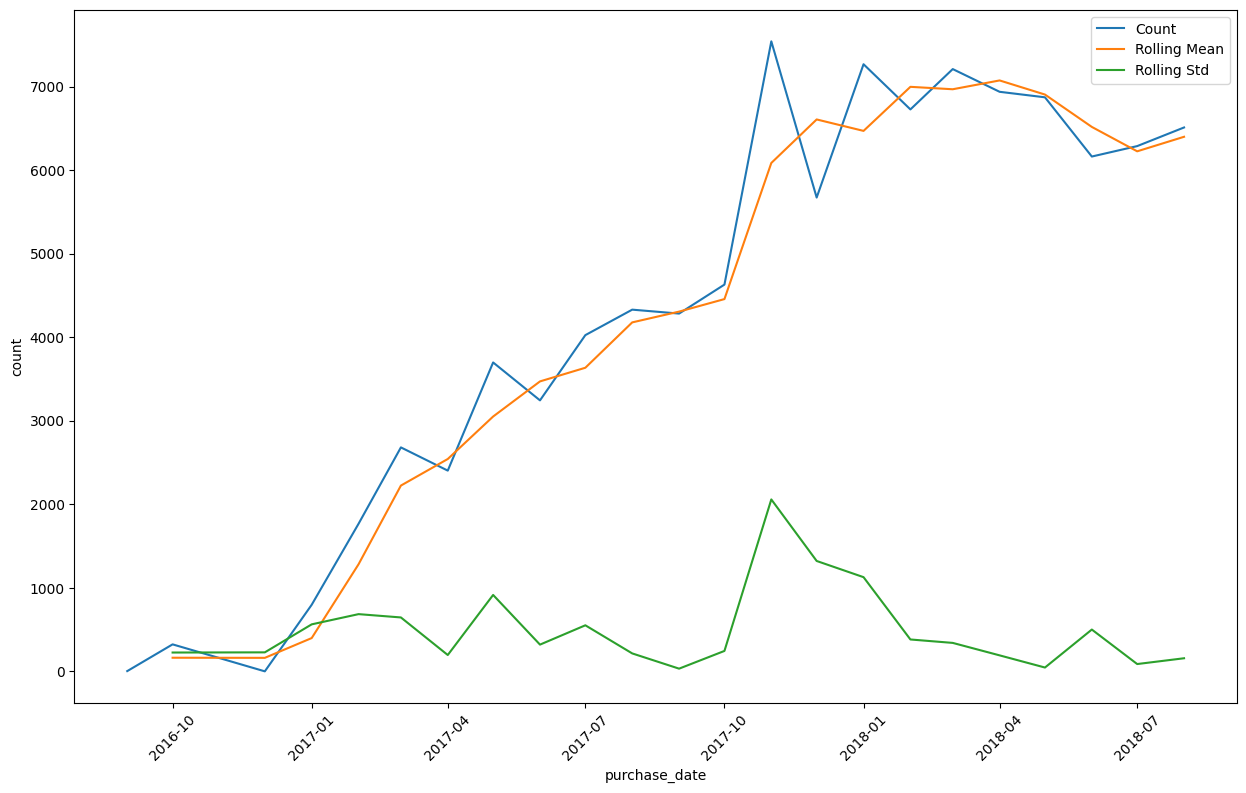

In [11]:
orders["purchase_date"] = pd.to_datetime(
    orders.order_purchase_timestamp.dt.strftime("%m/%Y")
)
purchase_attempts_by_date = (
    orders.loc[orders.purchase_date < "2018-09"]
    .groupby(by=["purchase_date"])["order_id"]
    .count()
    .reset_index(name="count")
)
purchase_attempts_by_date["rolling_mean"] = (
    purchase_attempts_by_date["count"].rolling(2).mean()
)
purchase_attempts_by_date["rolling_std"] = (
    purchase_attempts_by_date["count"].rolling(2).std()
)
sns.lineplot(
    data=purchase_attempts_by_date, x="purchase_date", y="count", label="Count"
)

sns.lineplot(
    data=purchase_attempts_by_date,
    x="purchase_date",
    y="rolling_mean",
    label="Rolling Mean",
)

sns.lineplot(
    data=purchase_attempts_by_date,
    x="purchase_date",
    y="rolling_std",
    label="Rolling Std",
)
plt.legend()
_ = plt.xticks(rotation=45)

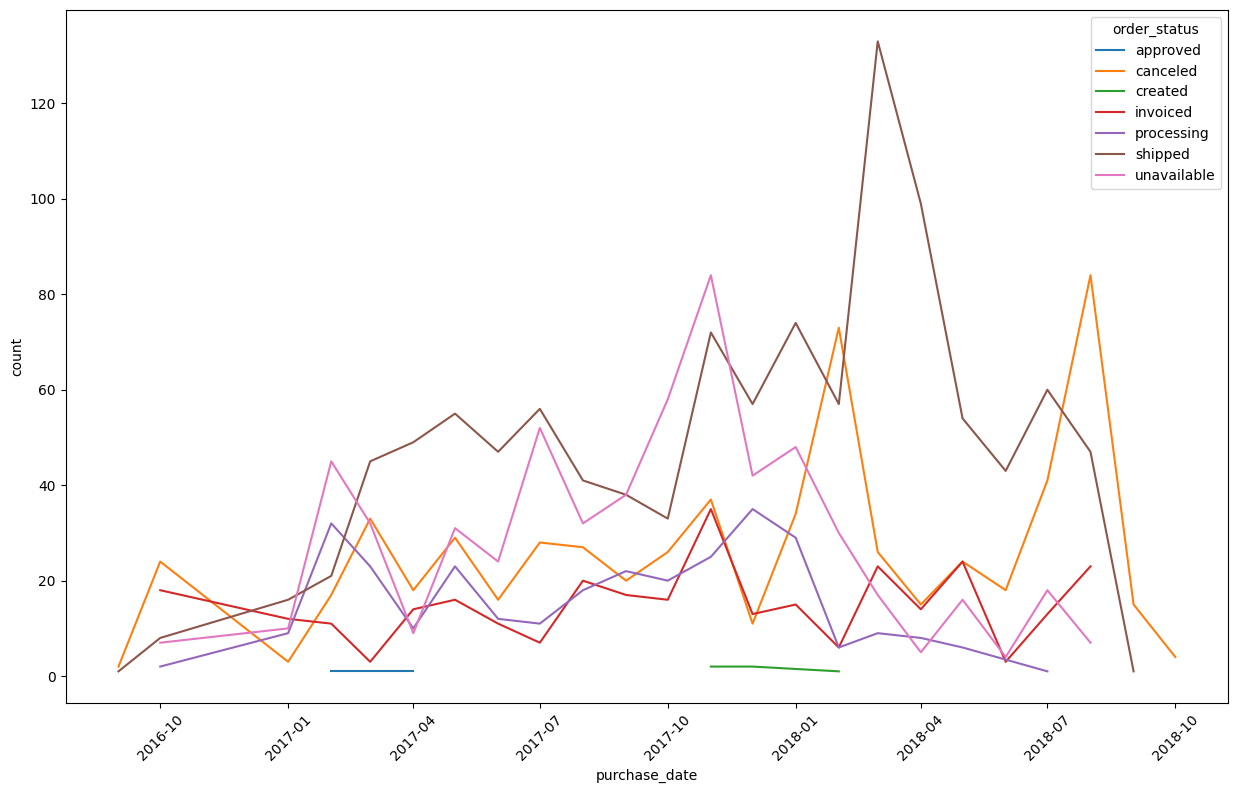

In [12]:
ax = sns.lineplot(
    data=orders[orders.order_status != "delivered"]
    .groupby(by=["order_status", "purchase_date"])["order_id"]
    .count()
    .reset_index(name="count"),
    x="purchase_date",
    y="count",
    hue="order_status",
)
_ = plt.xticks(rotation=45)

# Customers

In [13]:
customers = pd.read_csv("data/olist_customers_dataset.csv")

In [14]:
customers.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [15]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [16]:
customers.isna().any()

customer_id                 False
customer_unique_id          False
customer_zip_code_prefix    False
customer_city               False
customer_state              False
dtype: bool

## Loading cities dataset

In [17]:
municipios = pd.read_csv("data/municipios.csv")
municipios.is_capital = municipios.is_capital.fillna(False)
municipios.head(5)

C:\Users\Rafael\AppData\Local\Temp\ipykernel_10136\1900718628.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  municipios.is_capital = municipios.is_capital.fillna(False)


,municipio,uf,uf_code,name,mesoregion,microregion,rgint,rgi,osm_relation_id,wikidata_id,is_capital,wikipedia_pt,lon,lat,no_accents,slug_name,alternative_names,pop_21
0,1100015,11,RO,Alta Floresta d'Oeste,1102,11006,1102,110005,325842,Q1761456,False,Alta Floresta d'Oeste,-61.999824,-11.935540,Alta Floresta d'Oeste,alta-floresta-doeste,NaN,22516
1,1100023,11,RO,Ariquemes,1102,11003,1101,110002,325888,Q1646975,False,Ariquemes,-63.033269,-9.908463,Ariquemes,ariquemes,NaN,111148
2,1100031,11,RO,Cabixi,1102,11008,1102,110006,325882,Q940433,False,Cabixi,-60.544314,-13.499763,Cabixi,cabixi,NaN,5067
3,1100049,11,RO,Cacoal,1102,11006,1102,110005,325872,Q1761637,False,Cacoal,-61.442944,-11.433865,Cacoal,cacoal,NaN,86416
4,1100056,11,RO,Cerejeiras,1102,11008,1102,110006,325883,Q1803210,False,Cerejeiras,-60.818426,-13.195033,Cerejeiras,cerejeiras,NaN,16088


In [18]:
municipios.no_accents = municipios.no_accents.str.lower()
municipios = municipios.rename(
    columns={"uf_code": "customer_state", "no_accents": "customer_city"}
)
customers = customers.merge(
    municipios, how="left", on=["customer_state", "customer_city"]
)

## Customers per State

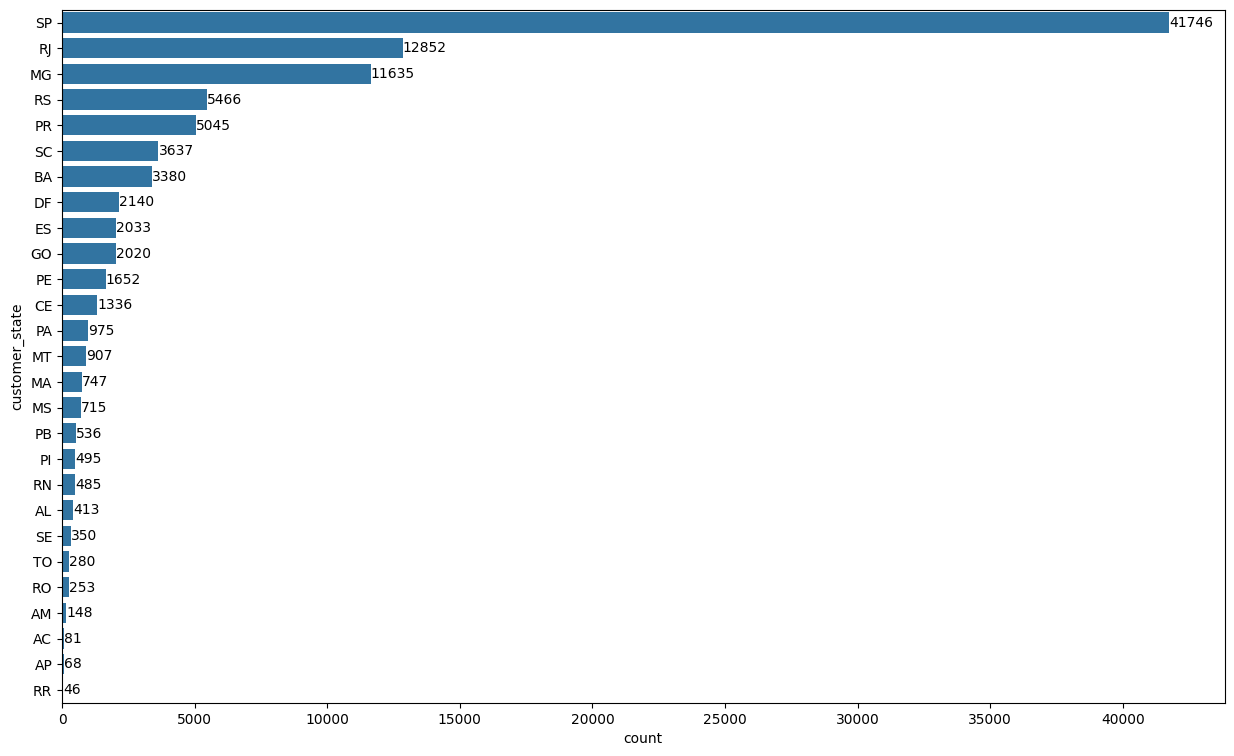

In [19]:
ax = sns.countplot(
    data=customers,
    y="customer_state",
    order=customers.customer_state.value_counts().index,
)
_ = ax.bar_label(ax.containers[0])

In [20]:
cities_to_plot = (
    customers.groupby(by=["lat", "lon"])  # noqa: E712
    .count()
    .reset_index()[["lat", "lon", "customer_id"]]
)
cities_to_plot = cities_to_plot.merge(
    municipios[
        [
            "lat",
            "lon",
            "customer_state",
            "name",
            "mesoregion",
            "microregion",
            "pop_21",
            "is_capital",
        ]
    ],
    on=["lat", "lon"],
)

cities_to_plot.rename(columns={"customer_id": "qtd_clientes"}, inplace=True)
cities_to_plot = cities_to_plot[~(cities_to_plot.is_capital)]

In [21]:
fig = px.scatter_mapbox(
    cities_to_plot,
    lat="lat",
    lon="lon",
    color="microregion",
    size="qtd_clientes",
    zoom=4,
    hover_name="name",
    hover_data="qtd_clientes",
)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [22]:
fig = make_subplots(rows=1, cols=2)
fig.append_trace(
    go.Box(y=cities_to_plot["qtd_clientes"], name="Qtd Clientes"), row=1, col=1
)
fig.append_trace(
    go.Box(y=cities_to_plot["pop_21"], name="População Cidades"), row=1, col=2
)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [23]:
print(scipy.stats.kendalltau(cities_to_plot.pop_21, cities_to_plot.qtd_clientes))
fig = px.scatter(cities_to_plot, x="pop_21", y="qtd_clientes", hover_data=["name"])
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

SignificanceResult(statistic=0.5280253846968186, pvalue=0.0)


# Cities with no costumers

In [24]:
cols_from_mun = [
    "lat",
    "lon",
    "pop_21",
    "customer_state",
    "name",
    "mesoregion",
    "microregion",
    "is_capital",
]
cities_to_plot = cities_to_plot.merge(
    municipios[cols_from_mun][~(municipios.is_capital)], how="right", on=cols_from_mun
)
cities_to_plot = cities_to_plot.fillna({"qtd_clientes": 0})

In [25]:
fig = px.scatter_mapbox(
    cities_to_plot[cities_to_plot.qtd_clientes == 0],
    lat="lat",
    lon="lon",
    color="microregion",
    size="pop_21",
    zoom=4,
    hover_name="name",
    hover_data="pop_21",
)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [26]:
fig = px.bar(
    cities_to_plot[cities_to_plot.qtd_clientes == 0].sort_values(
        by="pop_21", ascending=False
    )[:10],
    x="pop_21",
    y="name",
    hover_data="customer_state",
)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(yaxis={"categoryorder": "total ascending"})

# Items

In [34]:
items = pd.read_csv("data/olist_order_items_dataset.csv")
items.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [38]:
products = pd.read_csv("data/olist_products_dataset.csv")
products.head(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [36]:
items.product_id.nunique()
len(items)


112650

In [39]:
items = items.merge(products, on="product_id")

In [41]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   order_id                    112650 non-null  object 
 1   order_item_id               112650 non-null  int64  
 2   product_id                  112650 non-null  object 
 3   seller_id                   112650 non-null  object 
 4   shipping_limit_date         112650 non-null  object 
 5   price                       112650 non-null  float64
 6   freight_value               112650 non-null  float64
 7   product_category_name       111047 non-null  object 
 8   product_name_lenght         111047 non-null  float64
 9   product_description_lenght  111047 non-null  float64
 10  product_photos_qty          111047 non-null  float64
 11  product_weight_g            112632 non-null  float64
 12  product_length_cm           112632 non-null  float64
 13  product_height

In [42]:
items.isna().sum()

order_id                         0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name         1603
product_name_lenght           1603
product_description_lenght    1603
product_photos_qty            1603
product_weight_g                18
product_length_cm               18
product_height_cm               18
product_width_cm                18
dtype: int64

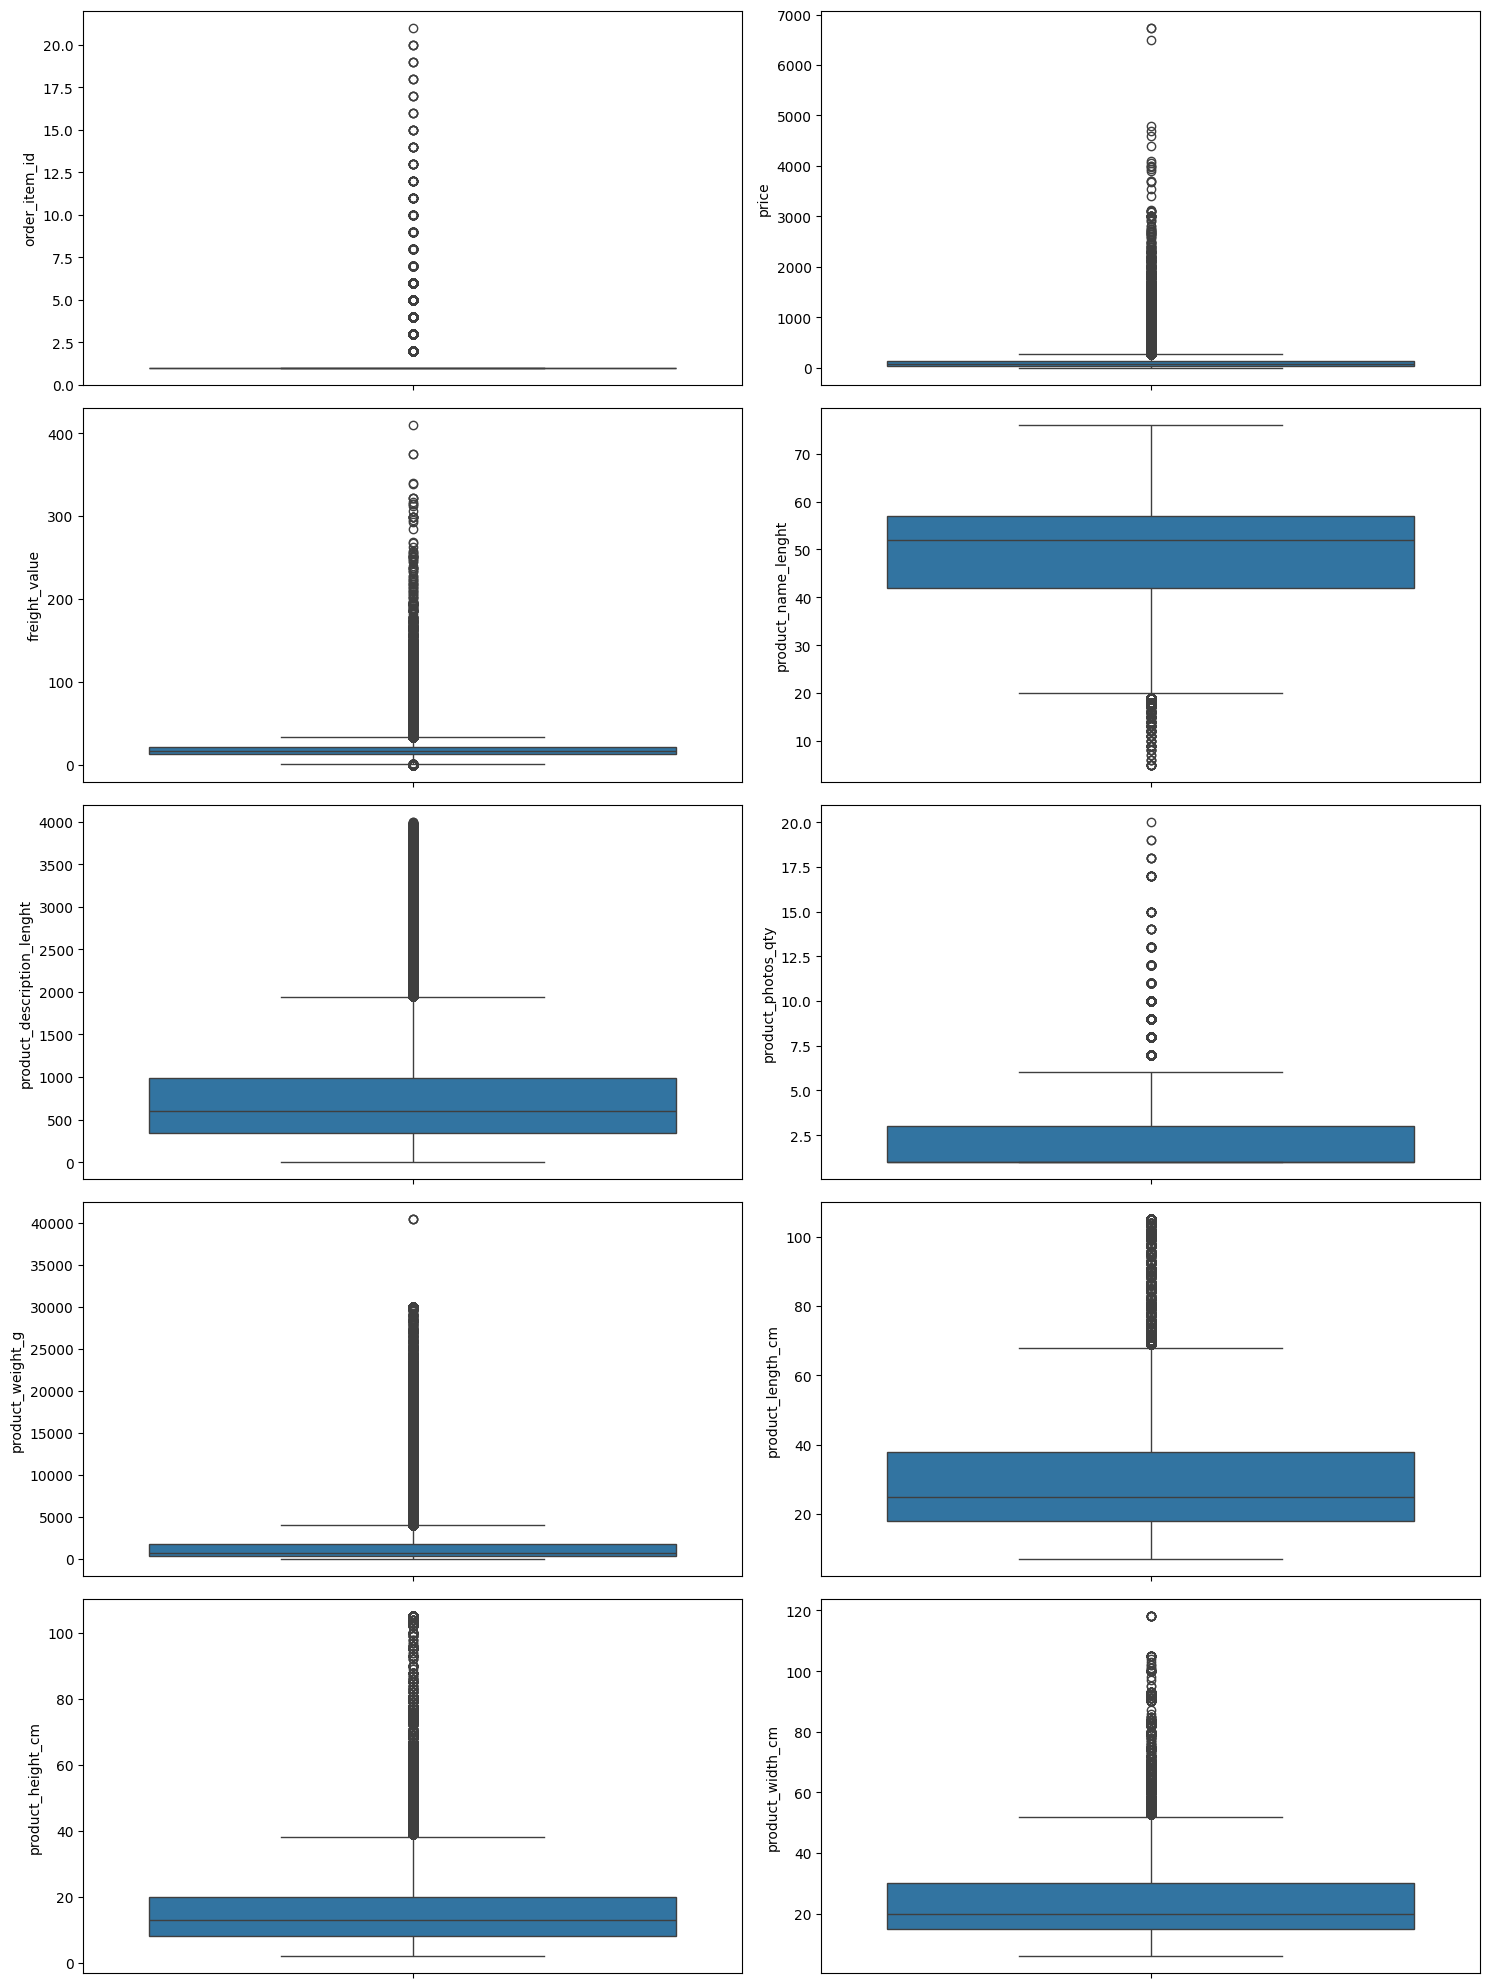

In [51]:
cols = items.select_dtypes("number").columns
fig, axs = plt.subplots(nrows=int(len(cols) / 2), ncols=2, figsize=(15, 20))
axs = axs.flatten()
for i, col in enumerate(cols):
    sns.boxplot(items[col], ax=axs[i])
fig.tight_layout()
